In [79]:
# Install pandas package
!pip install pandas
# Install nltk package
!pip install nltk
# Install contractions package
!pip install contractions
# Install scikit-learn package
!pip install scikit-learn
# Install matplotlib package
!pip install matplotlib

In [80]:
# Data manipulation and handling
import pandas as pd # For reading CSV files, handling dataframes, and general data manipulation
import re           # For regular expressions, useful in text cleaning
import string       # Provides string constants like punctuation

# Natural Language Processing (NLP)
import nltk                             # Natural Language Toolkit for NLP tasks
import contractions                     # For expanding contractions in text (e.g., "don't" -> "do not")
from nltk.corpus import stopwords       # For filtering out common words like "the", "is"
from nltk.stem import WordNetLemmatizer # For lemmatization: reducing words to their base form

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer # Convert text into TF-IDF feature vectors
from sklearn.model_selection import train_test_split        # Split data into training and testing sets
from sklearn.svm import LinearSVC                           # SVC classifier for text data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Evaluation metrics

# Visualization
import matplotlib.pyplot as plt # For plotting charts and visualizing data

In [81]:
nltk.download('punkt')                      # Tokenizer models
nltk.download('stopwords')                  # Common stopwords for English
nltk.download('wordnet')                    # WordNet dictionary for lemmatization
nltk.download('omw-1.4')                    # WordNet's multilingual support
nltk.download('averaged_perceptron_tagger') # Part-of-speech tagger for NLP tasks
nltk.download('maxent_ne_chunker')          # Named Entity Chunker
nltk.download('words')                      # Word corpus for NE chunking

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\minli\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already

True

In [82]:
# Load dataset
df = pd.read_csv(r"C:\Users\minli\Downloads\McDonald_s_Reviews.csv", encoding ='cp1252')

# Data Visualization

In [83]:
df.shape # Quick check for rows & columns

(33396, 10)

In [84]:
df.info() # Detailed column info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


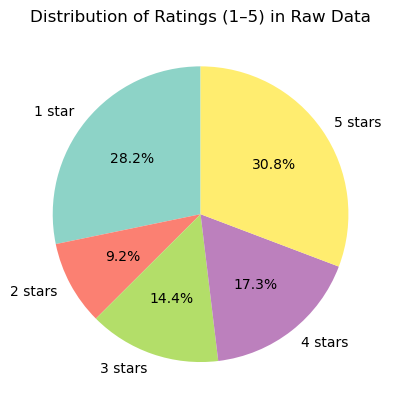

In [85]:
rating_counts = df['rating'].value_counts().sort_index()                      # Count reviews for each rating (1–5)
rating_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3') # Plot pie chart
plt.title("Distribution of Ratings (1–5) in Raw Data")                                    # Title of pie chart
plt.ylabel("")                                                                # Remove the default y-axis label for cleaner chart
plt.show()                                                                    # Display the chart

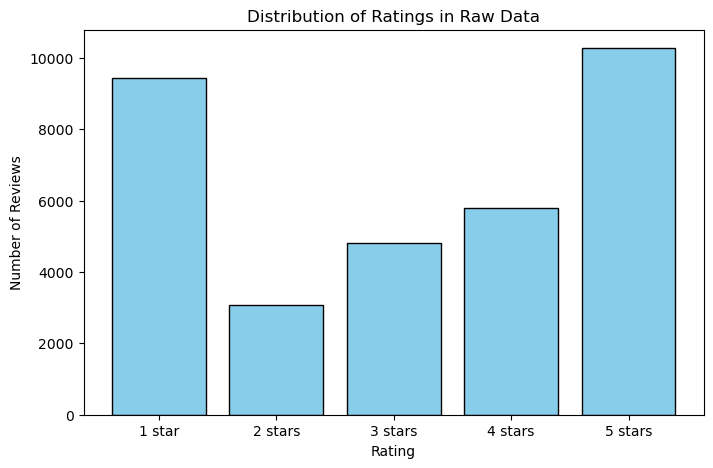

In [86]:
plt.figure(figsize=(8,5))
plt.bar(rating_counts.index.astype(str), rating_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings in Raw Data')
plt.show()

# Data Prepocessing

In [87]:
# Left 'Review' and 'Rating' only, clean null
df = df[['review', 'rating']].dropna()

In [88]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))  # Load English stopwords (remove articles, conjunctions)
lemmatizer = WordNetLemmatizer()              # Initialize WordNet lemmatizer (reduce words to their base form)
apply_spell_correction = False                # Set True to enable spell correction

In [89]:
# Cleaning data, reduce short term, become lowercase, remove punctuation & numbers, lemmatizer, link back word to a string
def clean_text(text):
    text = contractions.fix(str(text))                               # Remove short term
    text = str(text).lower()                                         # Covert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)                             # Remove  punctuation, emoji & numbers
    words = text.split()                                             # Tokenization (basic)
    if apply_spell_correction:                                       # Spell Correction
        from textblob import TextBlob
        words = [str(TextBlob(word).correct()) for word in words]
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]
    return ' '.join(cleaned_words)                                   # Rebuild cleaned text

# Apply cleaning to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

In [90]:
# Cleaning data, delete invalid review
df = df[df['cleaned_review'].str.strip() != '']
df = df.dropna(subset=['cleaned_review'])

In [91]:
# Convert Rating like '4 stars' to '4'
df['rating'] = df['rating'].astype(str).str.extract('(\d+)').astype(int)

In [92]:
# Add sentiment based on rating
def to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r >= 3:
        return "positive"

df['sentiment'] = df['rating'].apply(to_sentiment)

# TF-IDF

In [93]:
# Apply TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Split & Train Data

In [94]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the data
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

# Predict Results

In [95]:
# Predict result
print("***SVM Model Result Based On Test Data***")
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy on Test data:", round(accuracy_score(y_test, y_pred), 4))

***SVM Model Result Based On Test Data***

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83      2439
    positive       0.90      0.91      0.91      4209

    accuracy                           0.88      6648
   macro avg       0.87      0.87      0.87      6648
weighted avg       0.88      0.88      0.88      6648

Confusion Matrix:
[[1995  444]
 [ 358 3851]]

Accuracy on Test data: 0.8794


In [96]:
# List training result
print("***SVM Model Result Based On Train data***")
y_pred = model.predict(X_train)

print("\nClassification Report:")
print(classification_report(y_train, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("\nAccuracy on Train data:", round(accuracy_score(y_train, y_pred), 4))

***SVM Model Result Based On Train data***

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86     10022
    positive       0.91      0.92      0.91     16570

    accuracy                           0.89     26592
   macro avg       0.89      0.88      0.88     26592
weighted avg       0.89      0.89      0.89     26592

Confusion Matrix:
[[ 8512  1510]
 [ 1360 15210]]

Accuracy on Train data: 0.8921


# Visualization (Sentiment Distribution)

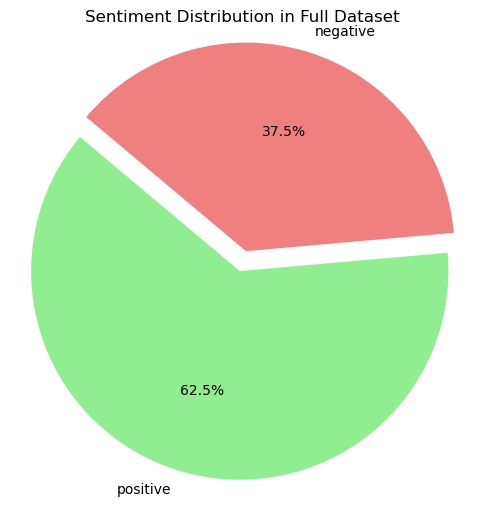

In [97]:
# Count sentiment values
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['lightgreen', 'lightcoral']  # positive, negative
explode = (0.05, 0.05)                 # to separate slices a bit

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title('Sentiment Distribution in Full Dataset')
plt.axis('equal')                      # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Predict User Input

In [99]:
unseen_reviews = [input("Enter a review: ")]
unseen_cleaned = [clean_text(r) for r in unseen_reviews]        # Clean user input using clean_text()
unseen_features = vectorizer.transform(unseen_cleaned)          # Covert input into TF-IDF
predicted_sentiment = model.predict(unseen_features)            # Making prediction
print(f"Predicted Sentiment: {predicted_sentiment[0]}")         # Print results (positive/negative)

Enter a review:  hello


Predicted Sentiment: positive


# Store the model in Joblib

In [100]:
# for streamlit predictions instantly
from joblib import dump, load
dump(model, 'SVM.joblib')
dump(vectorizer, 'tfidf_vectorizer.joblib')

# In Steamlit (load without retraining)
model = load('SVM.joblib')
vectorizer = load('tfidf_vectorizer.joblib')

# Store Clearned data

In [101]:
# Save cleaned data in.csv
df_to_save = df[['review', 'cleaned_review', 'sentiment']]
df_to_save.to_csv(r"C:\tarc\Degree\Y1S3\AI ASM\cleaned_reviews_with_sentiment.csv", index=False)